In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib widget
import ipywidgets as widgets

import lib.setFigureConfig as sfc
np.random.seed(42)
from lib.colorschemes import tol_cmap, tol_cset

from lib.vectors import random_direction, lorentz_transform, angle_between, scatter_4vector
from lib.inverseCompton import cos_theta_thomson, mu_KN_integrated_inv, omega_min, omega_max, IC_kernel_vec, dsigma_KNdmu, sigma_KN
from lib.visualize import plot_photon
from bisect import bisect_left

In [2]:
# suppress warnings to keep widget layout nice
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Some useful definitions
c_light=3.e10              # speed of light--always useful       
m_electron=9.10938356e-28  # electron mass
sigma_t=6.65e-25           # Thomson cross section
mec2 = m_electron*c_light**2
eV2erg = 1.60218e-12
erg2eV = 1/eV2erg

In [4]:
def updateplot(
        betaGamma_el, eldelta, elcostheta, elphi, mu_el_min, mu_el_max,
        E_ph_in_eV, phdelta, phcostheta, phphi, mu_phot_min, mu_phot_max,
        N_MC, N_phot_plot, NDots, blackDots, alphaDots, plotElOut, plotElIn):

    N_MC = int(N_MC)
    for ax_i in [ax, axmu]:
        for line in ax_i.get_lines():
            line.remove()

    # sample photons
    hnu= E_ph_in_eV*eV2erg # erg
    if phdelta:
        sinphtheta = np.sin(np.arccos(phcostheta))
        p_photon_in = hnu/c_light * np.array([[1, sinphtheta*np.cos(phphi),sinphtheta*np.sin(phphi),phcostheta] for i in range(N_MC)])
    else:
        p_photon_in = hnu/c_light * random_direction(N_MC, True, mu_phot_min, mu_phot_max)

    # sample electrons
    if eldelta:
        sineltheta = np.sin(np.arccos(elcostheta))
        n_el_in = np.array([[sineltheta*np.cos(elphi),sineltheta*np.sin(elphi),elcostheta] for i in range(N_MC)])
    else:
        n_el_in = random_direction(N_MC, False, mu_el_min, mu_el_max)
    bGel = betaGamma_el
    Gel = np.sqrt(1 + bGel**2)
    bel = np.sqrt(1 - 1/Gel**2)

    # boost photons
    p_photon_in_prime= np.empty_like(p_photon_in)
    lorentz_transform(p_photon_in, bel*n_el_in, Gel, p_photon_in_prime)
    
    # scatter photons
    p_photon_out_prime= np.empty_like(p_photon_in_prime)
    phi_scatter = np.random.uniform(0, 2*np.pi, N_MC)
    cos_theta_scatter = np.random.uniform(-1, 1, N_MC)
    p0_new = p_photon_in_prime[:,0] / (1.0 + (p_photon_in_prime[:,0] / m_electron / c_light) * (1.0 - cos_theta_scatter))
    
    scatter_4vector(p_photon_in_prime, phi_scatter, cos_theta_scatter, p0_new, p_photon_out_prime)

    # boost back
    p_photon_out = np.empty_like(p_photon_out_prime)
    lorentz_transform(p_photon_out_prime, -bel*n_el_in, Gel, p_photon_out)

    # calculate angles
    cos_alpha_in = angle_between(p_photon_in[:,1], p_photon_in[:,2], p_photon_in[:,3], n_el_in[:,0], n_el_in[:,1], n_el_in[:,2])
    cos_alpha_out = angle_between(p_photon_out[:,1], p_photon_out[:,2], p_photon_out[:,3], n_el_in[:,0], n_el_in[:,1], n_el_in[:,2])
    cos_thetas_prime = angle_between(p_photon_in_prime[:,1], p_photon_in_prime[:,2], p_photon_in_prime[:,3], 
                                          p_photon_out_prime[:,1], p_photon_out_prime[:,2], p_photon_out_prime[:,3])
    cos_alpha_scattering = angle_between(p_photon_in[:,1], p_photon_in[:,2], p_photon_in[:,3], p_photon_out[:,1], p_photon_out[:,2], p_photon_out[:,3])

    # calculate weights
    weights_vecs = (1-bel*cos_alpha_in) * (mu_phot_max-mu_phot_min) * dsigma_KNdmu(p_photon_in_prime[:,0]/m_electron/c_light, cos_theta_scatter) / N_MC
        
    # plot the 2D distributions
    axa.clear()
    axb.clear()
    # if Greensplot:
    #     Nscatter = 10000
    #     index_scatter = np.array(np.random.uniform(0, N_MC-1, Nscatter), dtype=int)
    #     Ein_scatter = p_photon[index_scatter][:,0]*c_light/mec2
    #     cosain_scatter = cos_alpha_ins_fast[index_scatter]
    #     col_scatter = tol_cmap("rainbow_PuRd")((cosain_scatter+1)/2)
    #     axb.scatter(np.log10(Ein_scatter), cosain_scatter, c=col_scatter, marker=".")
    #     Eout_scatter = p_out_fast[index_scatter][:,0]*c_light/mec2
    #     cosaout_scatter = cos_alpha_outs_fast[index_scatter]
    #     axa.scatter(np.log10(Eout_scatter), cosaout_scatter, c=col_scatter, marker=".")
    #     axa.axvline(np.log10(hnu/mec2), c="k")
    # else:
    axb.hist2d(np.log10(p_photon_in[:,0]*c_light/mec2), cos_alpha_in, weights=weights_vecs, density=True,
                bins=[np.linspace(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1), 100),
                        np.linspace(-1, 1, 100)], cmap=tol_cmap("rainbow_PuRd"))
    axa.hist2d(np.log10(p_photon_out[:,0]*c_light/mec2), cos_alpha_out, weights=weights_vecs, density=True,
                bins=[np.linspace(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1), 100),
                        np.linspace(-1, 1, 100)], cmap=tol_cmap("rainbow_PuRd"))
    axa.axvline(np.log10(hnu/mec2), c="w", ls="--")

    axb.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
    axb.set_title(r"before: $\frac{d N}{d\log_{10}(E/m_ec^2) d\cos \alpha_{scat}}$")
    axb.set_ylabel(r"scattering angle $\cos \alpha_{scat}$")
    axa.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
    axa.set_title(r"after: $\frac{d N}{d\log_{10}(E/m_ec^2) d\cos \alpha_{scat}}$")
    axa.set_ylabel(r"scattering angle $\cos \alpha_{scat}$")
    fig3.tight_layout()

    # plot the 1D histograms
    hist, bins=np.histogram(np.log10(p_photon_out[:,0]*c_light/mec2),bins=100,density=False, weights=weights_vecs) # dN/dlog10(E/mec2)
    tmid=0.5*(bins[1:]+bins[:-1]) #+ np.log10(c_light)
    hist/= bins[1]- bins[0]
    ax.plot(tmid, hist/np.log(10),c=list(tol_cset("muted"))[0],  label=r"MC")


    Eouts = np.logspace(np.log10(omega_min(hnu/mec2, Gel)), np.log10(omega_max(hnu/mec2, Gel)), 1000) * mec2
    # dlogE = np.log(Eouts[1]/Eouts[0])
    IC_kernel_plot = IC_kernel_vec(hnu, bGel, Eouts)* Eouts/mec2
    integral = 1 #np.sum(IC_kernel_plot) * dlogE
    # print(integral)
    ax.plot(np.log10(Eouts/mec2), IC_kernel_plot / integral, color=list(tol_cset("muted"))[1], label="isotr. (Sarkar++19)", ls="--")


    # Eouts = np.logspace(np.log10(hnu)-1, np.log10(Gel)+0.5, 300)
    # Eelin = Gel * mec2
    b = 4 * Gel * hnu/m_electron/c_light**2
    # q = Eouts/Eelin /b/ (1 - Eouts/Eelin)
    # # log_a (b) = ln(b)/ln(a)
    # ax.plot(np.log10(Eouts/mec2), 3/4 *(2*q*np.log(q) + (1+2*q)*(1-q)+0.5*(b*q)**2/(1+b*q)*(1-q)) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls="-.", label="BG70 iso. analytical") 
    # ax.plot(np.log10(Eouts/mec2), 3/4 *(-2*q*np.log(q) ) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls=":") 
    # ax.plot(np.log10(Eouts/mec2), 3/4 *((1+2*q)*(1-q) ) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls="--") 
    # e1hat = Eouts/ 4/ Gel**2 / hnu
    # ax.plot(np.log10(Eouts/mec2), (2*e1hat*np.log(e1hat) + e1hat + 1 - 2* e1hat**2) *Eouts *np.log(10) /( 4*Gel**2 * hnu) * 3, c="tab:red", ls="--", label="iso. ana. Thomson")
    ax.set_title(r"$\Gamma_{e} E_{\gamma,in}/(m_e c^2)^2$" + f"={b/4.:.1e}", loc="right")
    ax.set_xlim(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1))
    axb.set_xlim(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1))
    axa.set_xlim(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1))
    axb.set_ylim(-1, 1)
    axa.set_ylim(-1, 1)
    ax.legend()


    axmu.set_xlim(-1.1, 1.1)
    # axmu.set_xlabel(r"$\cos \alpha_{scattering}$")
    # axmu.set_xlabel(r"cos angle")
    # ax2.set_ylim(1e-6, 10)
    axmu.set_yscale("log")
    axmu.grid(alpha=0.3)

    hist, bins=np.histogram(cos_alpha_scattering,bins=100,density=False, weights=weights_vecs) 
    tmid=0.5*(bins[1:]+bins[:-1]) #+ np.log10(c_light)
    hist/= bins[1]- bins[0]
    axmu.plot(tmid, hist,c=list(tol_cset("muted"))[0],  label=r"MC")
    
    mus_plot = np.linspace(-1, 1, 300)
    axmu.plot(mus_plot, (1+mus_plot**2)* 3/8, c="k", ls="-", label="Thomson approx. (ERF)")
    # axmu.plot(mus_plot, dsigma_KNdmu(hnu/mec2, mus_plot)/sigma_KN(hnu/mec2), c="grey", ls="--", label="KN")
    axmu.plot(mus_plot, dsigma_KNdmu(hnu/mec2, mus_plot), c="grey", ls="--", label="Klein-Nishina (ERF)")
    axmu.legend()
    # ax2.set_title(r"$\Gamma_{el} E_{in}/mc^2=" + f"{G*hnu/mec2:.1e}" + r"$")

    fig.tight_layout()

    # plot 3D plots
    # Nscatter3D = 1000
    # # sample photons
    # if phdelta:
    #     sinphtheta = np.sin(np.arccos(phcostheta))
    #     p_photon_in = hnu/c_light * np.array([[1, sinphtheta*np.cos(phphi),sinphtheta*np.sin(phphi),phcostheta] for i in range(Nscatter3D)])
    # else:
    #     p_photon_in = hnu/c_light * random_direction(Nscatter3D, True, mu_phot_min, mu_phot_max)

    # # sample electrons
    # if eldelta:
    #     sineltheta = np.sin(np.arccos(elcostheta))
    #     n_el_in = np.array([[sineltheta*np.cos(elphi),sineltheta*np.sin(elphi),elcostheta] for i in range(Nscatter3D)])
    # else:
    #     n_el_in = random_direction(Nscatter3D, False, mu_el_min, mu_el_max)

    # # boost photons
    # p_photon_in_prime= np.empty_like(p_photon_in)
    # lorentz_transform(p_photon_in, bel*n_el_in, Gel, p_photon_in_prime)
    
    # # scatter photons
    # p_photon_out_prime= np.empty_like(p_photon_in_prime)
    # phi_scatter = np.random.uniform(0, 2*np.pi, Nscatter3D)
    # cos_theta_scatter = np.random.uniform(-1, 1, Nscatter3D)
    # p0_new = p_photon_in_prime[:,0] / (1.0 + (p_photon_in_prime[:,0] / m_electron / c_light) * (1.0 - cos_theta_scatter))

    # uniform_p = np.random.uniform(0, 1, Nscatter3D)
    # mu_array_small = np.linspace(-1,1, 1000)
    # mu_array_large = np.linspace(-1,1, 10000)
    # cos_theta_scatter = np.array([
    #     mu_KN_integrated_inv(
    #         uniform_p[i], p_photon_in_prime[i][0]*c_light/mec2, 
    #         mu_array_small, mu_array_large) for i in range(Nscatter3D)])
    # p0_new = p_photon_in_prime[:,0] / (1.0 + (p_photon_in_prime[:,0] / m_electron / c_light) * (1.0 - cos_theta_scatter))
    # scatter_4vector(p_photon_in_prime, phi_scatter, cos_theta_scatter, p0_new, p_photon_out_prime)

    # # boost back
    # p_photon_out = np.empty_like(p_photon_out_prime)
    # lorentz_transform(p_photon_out_prime, -bel*n_el_in, Gel, p_photon_out)

    cmap = tol_cmap("rainbow_PuRd")
    colmin = min(np.log10(p_photon_out[:,0]*c_light))
    colmax = max(np.log10(p_photon_out[:,0]*c_light))
    norm = Normalize(vmin=colmin, vmax=max(colmin+1, colmax))
    for ax_i in [ax1, ax2, ax3, ax4]:
        for line in ax_i.get_lines():
            line.remove()
        for line in ax_i.collections:
            line.remove()
        
    fac = 4
    cum_weights = np.cumsum(weights_vecs)
    cdf = cum_weights/cum_weights[-1]
    random_vals_plot = np.random.rand(N_phot_plot)
    indices = np.searchsorted(cdf, random_vals_plot)
    for index in indices:
        p_photon_plot = p_photon_in[index][1:] / p_photon_in[index][0]
        plot_photon(ax1, -fac*p_photon_plot, p_photon_plot, color=cmap(norm(np.log10(hnu))), colortip=cmap(norm(np.log10(hnu))))
        
        p_photon_prime_plot = p_photon_in_prime[index][1:] / p_photon_in_prime[index][0]
        plot_photon(ax2, -fac*p_photon_prime_plot, p_photon_prime_plot, 
                    color=cmap(norm(np.log10(p_photon_in_prime[index][0]*c_light))), 
                    colortip=cmap(norm(np.log10(p_photon_in_prime[index][0]*c_light))))
        
        p_out_prime_plot = p_photon_out_prime[index][1:] / p_photon_out_prime[index][0]
        plot_photon(ax4, np.zeros(3), p_out_prime_plot, 
                    color=cmap(norm(np.log10(p_photon_out_prime[index][0]*c_light))), colortip=cmap(norm(np.log10(p_photon_out_prime[index][0]*c_light))))
        
        p_out_plot = p_photon_out[index][1:] / p_photon_out[index][0]
        plot_photon(ax3, np.zeros(3), p_out_plot, 
                    color=cmap(norm(np.log10(p_photon_out[index][0]*c_light))), colortip=cmap(norm(np.log10(p_photon_out[index][0]*c_light))))
        
        if plotElOut:
            p_el_in_plot = m_electron*c_light * np.array([Gel, *(betaGamma_el*n_el_in[index])] )
            p_el_out_plot = p_photon_in[index] + p_el_in_plot - p_photon_out[index]
            # n_el_out_plot = p_el_out_plot[1:] / p_el_out_plot[0]
            # p_el_out_tot = np.sqrt(p_el_out_plot[1]**2 + p_el_out_plot[2]**2 + p_el_out_plot[3]**2)
            num_waves = 4
            plot_photon(ax3, [0,0,0], p_el_out_plot[1:], amplitude=0., color="k", colortip="k", cone_size=0.3, ls="-", num_waves=num_waves)

    if plotElIn:
        plot_photon(ax1, -fac*n_el_in[0], n_el_in[0], amplitude=0., color="k", colortip="k", cone_size=0.3)
        plot_photon(ax3, -fac*n_el_in[0], n_el_in[0], amplitude=0., color="grey", colortip="grey", cone_size=0.3, ls="--")
    else:
        ax1.plot([0], [0], [0], marker="o", color="k")
        ax3.plot([0], [0], [0], marker="o", color="k")

    ax2.plot([0], [0], [0], marker="o", color="k")
    ax4.plot([0], [0], [0], marker="o", color="k")

    c_sphere = "k"
    selection = np.searchsorted(cdf, np.random.rand(min(NDots,N_MC)))
    if alphaDots> 1e-5:
        p_photon_scatter1 = fac* p_photon_in[selection,1] / p_photon_in[selection,0]
        p_photon_scatter2 = fac* p_photon_in[selection,2] / p_photon_in[selection,0]
        p_photon_scatter3 = fac* p_photon_in[selection,3] / p_photon_in[selection,0]
        if blackDots:
            colordots = c_sphere
        else:
            colordots = cmap(norm(np.log10(p_photon_in[selection,0]*c_light)))
        ax1.scatter3D(p_photon_scatter1, p_photon_scatter2, p_photon_scatter3, color=colordots, alpha=alphaDots, marker=".")

        p_photon_prime_scatter1 = fac* p_photon_in_prime[selection,1] / p_photon_in_prime[selection,0]
        p_photon_prime_scatter2 = fac* p_photon_in_prime[selection,2] / p_photon_in_prime[selection,0]
        p_photon_prime_scatter3 = fac* p_photon_in_prime[selection,3] / p_photon_in_prime[selection,0]
        if blackDots:
            colordots = c_sphere
        else:
            colordots = cmap(norm(np.log10(p_photon_in_prime[selection,0]*c_light)))
        ax2.scatter3D(p_photon_prime_scatter1, p_photon_prime_scatter2, p_photon_prime_scatter3, color=colordots, alpha=alphaDots, marker=".")
            
        p_out_scatter1 = fac* p_photon_out[selection,1] / p_photon_out[selection,0]
        p_out_scatter2 = fac* p_photon_out[selection,2] / p_photon_out[selection,0]
        p_out_scatter3 = fac* p_photon_out[selection,3] / p_photon_out[selection,0]
        if blackDots:
            colordots = c_sphere
        else:
            colordots = cmap(norm(np.log10(p_photon_out[selection,0]*c_light)))
        ax3.scatter3D(p_out_scatter1, p_out_scatter2, p_out_scatter3, color=colordots, alpha=alphaDots, marker=".")
        
    
        p_out_prime_scatter1 = fac* p_photon_out_prime[selection,1] / p_photon_out_prime[selection,0]
        p_out_prime_scatter2 = fac* p_photon_out_prime[selection,2] / p_photon_out_prime[selection,0]
        p_out_prime_scatter3 = fac* p_photon_out_prime[selection,3] / p_photon_out_prime[selection,0]
        if blackDots:
            colordots = c_sphere
        else:
            colordots = cmap(norm(np.log10(p_photon_out_prime[selection,0]*c_light)))
        ax4.scatter3D(p_out_prime_scatter1, p_out_prime_scatter2, p_out_prime_scatter3, color=colordots, alpha=alphaDots, marker=".")
        
        fig2.tight_layout()

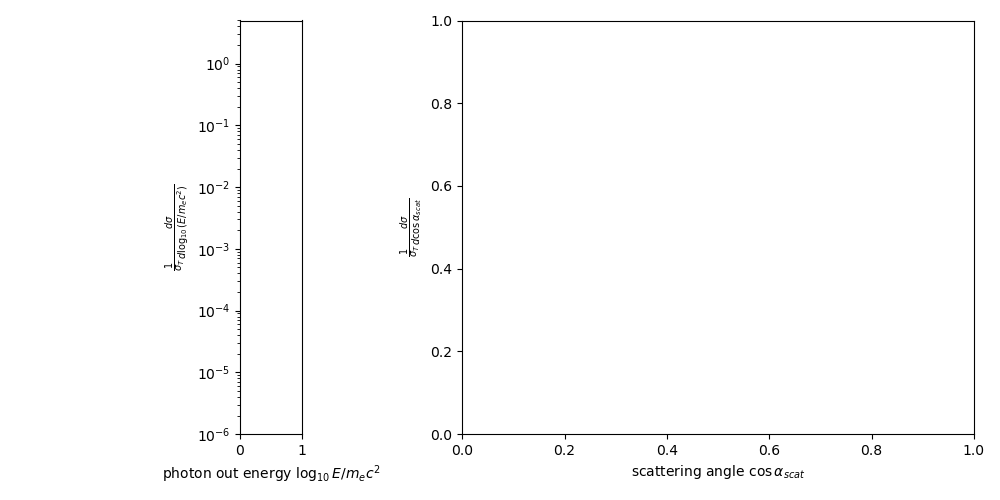

In [5]:
%matplotlib widget
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"$\frac{1}{\sigma_T} \frac{d \sigma}{d\log_{10}(E/m_ec^2)}$")
axmu.set_xlabel(r"scattering angle $\cos \alpha_{scat}$")
axmu.set_ylabel(r"$\frac{1}{\sigma_T} \frac{d \sigma}{d\cos \alpha_{scat}}$")
# ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()


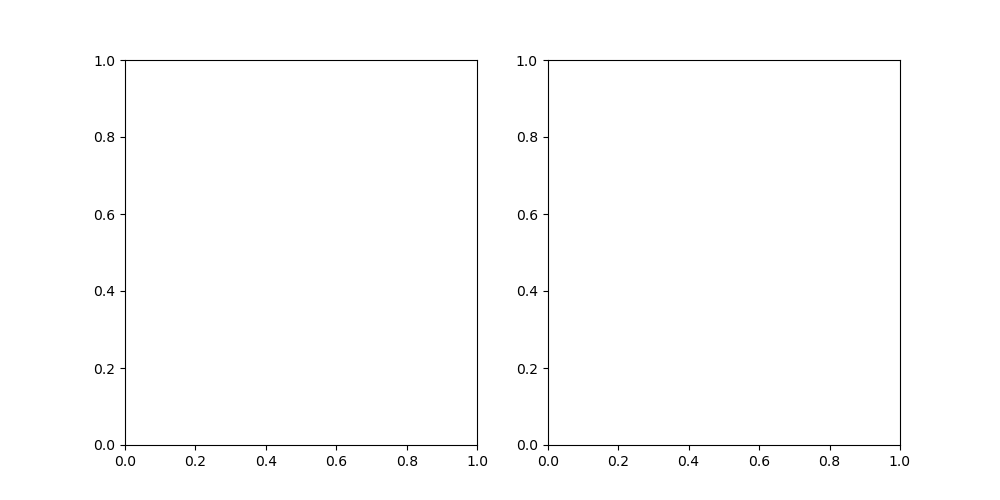

In [6]:
fig3, (axb, axa) = plt.subplots(ncols=2, figsize=(10, 5))

Text(0.5, 0.8648, 'lab frame after scattering')

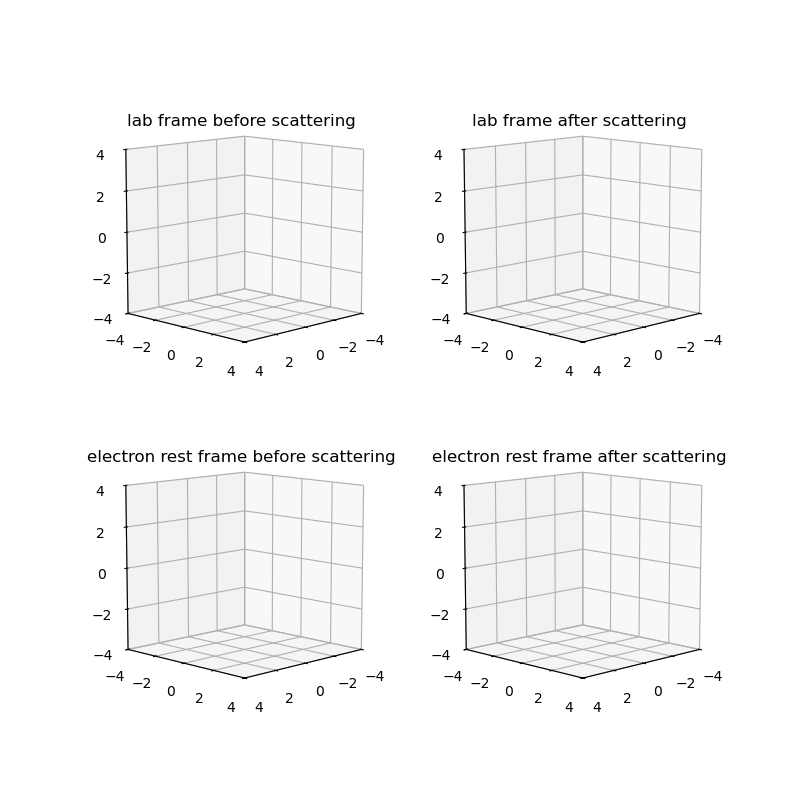

In [7]:
fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'})
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)


In [8]:
style = {'description_width': 'initial'}
widdies = widgets.interactive(
    updateplot, 
    betaGamma_el=widgets.FloatLogSlider(min=-7, max=10, step=.1, value=2, description="p/mc²", style=style),
    eldelta=widgets.Checkbox(value=True, description="single direction?", style=style),
    elcostheta=widgets.FloatSlider(min=-1, max=1, step=.001, value=1,readout_format=".3f", description="cos(theta)", style=style),
    elphi=widgets.FloatSlider(min=0, max=3, step=.1, value=1, description="phi", style=style),
    mu_el_min=widgets.FloatSlider(min=-1, max=1, step=.001, value=-1,readout_format=".3f", style=style),
    mu_el_max=widgets.FloatSlider(min=-1, max=1, step=.001, value=1,readout_format=".3f", style=style),
    E_ph_in_eV=widgets.FloatLogSlider(min=-10, max=12, step=.1, value=1),
    phdelta=widgets.Checkbox(value=False, description="single direction?", style=style),
    phcostheta=widgets.FloatSlider(min=-1, max=1, step=.001, value=-1,readout_format=".3f", description="cos(theta)", style=style),
    phphi=widgets.FloatSlider(min=0, max=3, step=.1, value=1, description="phi", style=style),
    mu_phot_min=widgets.FloatSlider(min=-1, max=1, step=.001, value=-1,readout_format=".3f", style=style),
    mu_phot_max=widgets.FloatSlider(min=-1, max=1, step=.001, value=1,readout_format=".3f", style=style),
    N_MC=widgets.FloatLogSlider(min=1, max=7, step=.01, value=1e5, description="# MC samples", style=style),
    N_phot_plot=widgets.IntSlider(min=1, max=50, step=1, value=5, description="# plotted photons", style=style),
    NDots=widgets.IntSlider(min=1, max=10000, step=1, value=1000, description="# photon scatter", style=style),
    blackDots=widgets.Checkbox(value=False, description="black scattered dots?", style=style),
    alphaDots=widgets.FloatLogSlider(min=-3.1, max=0, step=.01, value=-2,readout_format=".1e", description="scatter transparency", style=style),
    plotElOut=widgets.Checkbox(value=False, description="plot electron out arrows?", style=style),
    plotElIn=widgets.Checkbox(value=True, description="plot electron in arrows", style=style)
)
elbox = widgets.VBox([
    widgets.Label("electrons", layout=widgets.Layout(display="flex", justify_content="center")),
    *widdies.children[0:4],
    widgets.Label("if no single direction", layout=widgets.Layout(display="flex", justify_content="center")),
    *widdies.children[4:6]])
phobox = widgets.VBox([
    widgets.Label("photons", layout=widgets.Layout(display="flex", justify_content="center")), 
    *widdies.children[6:10],
    widgets.Label("if no single direction", layout=widgets.Layout(display="flex", justify_content="center")),
    *widdies.children[10:12]])
visbox = widgets.VBox([widgets.Label("visualization", layout=widgets.Layout(display="flex", justify_content="flex-start")), *widdies.children[12:]])
display(widgets.HBox([elbox, phobox, visbox]))